# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
%config IPCompleter.greedy=True

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

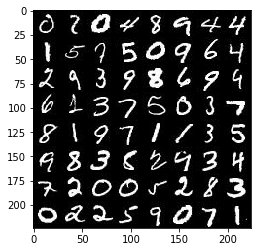

In [3]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

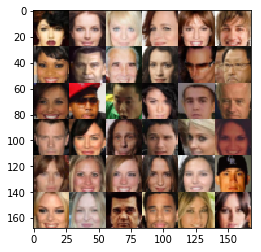

In [4]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='inputs_real')
    inputs_z=tf.placeholder(tf.float32,(None,z_dim),name='inputs_z')
    learning_rate=tf.placeholder(tf.float32,None,name='learning_rate')

    return inputs_real,inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.05
    keep_prob=0.5
    with tf.variable_scope('discriminator',reuse=reuse):
        x1=tf.layers.conv2d(images,
                            64,
                            5,
                            strides=2,
                            padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1=tf.maximum(alpha*x1,x1)
        
        x2=tf.layers.conv2d(relu1,
                            128,
                            5,
                            strides=2,
                            padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2=tf.layers.batch_normalization(x2,training=True)
        relu2=tf.maximum(alpha*bn2,bn2)
        d2=tf.nn.dropout(relu2,keep_prob=keep_prob)
        
        x3=tf.layers.conv2d(relu2,
                            256,
                            5,
                            strides=2,
                            padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3=tf.layers.batch_normalization(x3,training=True)
        relu3=tf.maximum(alpha*bn3,bn3)
        d3=tf.nn.dropout(relu3,keep_prob=keep_prob)
        
        flat=tf.reshape(relu3,(-1,4*4*256))
        logits=tf.layers.dense(flat,1)
        out=tf.sigmoid(logits)

    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        alpha=0.05
        
        x1=tf.layers.dense(z,7*7*256)
        x1=tf.reshape(x1,(-1,7,7,256))
        x1=tf.layers.batch_normalization(x1,training=is_train)
        x1=tf.maximum(alpha*x1,x1)
        
        x2=tf.layers.conv2d_transpose(x1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2=tf.layers.batch_normalization(x2,training=is_train)
        x2=tf.maximum(alpha*x2,x2)
        
        x3=tf.layers.conv2d_transpose(x2,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3=tf.layers.batch_normalization(x3,training=is_train)
        x3=tf.maximum(alpha*x3,x3)
        
        logits=tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=1,padding='same',
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out=tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    g_model=generator(input_z,out_channel_dim,is_train=True)
    d_model_real,d_logits_real=discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake=discriminator(g_model,reuse=True)
    
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    d_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    d_loss=d_loss_real+d_loss_fake
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars=tf.trainable_variables()
    d_vars=[var for var in t_vars if var.name.startswith('discriminator')]
    g_vars=[var for var in t_vars if var.name.startswith('generator')]
    
    update_ops=tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates=[opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        d_train_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt,g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    size=data_shape[1]
    dim=3 if data_image_mode=='RGB' else 1
    
    input_real,input_z,var_learning_rate=model_inputs(size,size,dim,z_dim)
    
    d_loss,g_loss=model_loss(input_real,input_z,dim)
    d_opt,g_opt=model_opt(d_loss,g_loss,var_learning_rate,beta1)
    
    samples,losses=[],[]
    steps=0
    print_every=10
    show_every=100
    
    saver=tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                images=batch_images*2
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                _=sess.run(d_opt,feed_dict={
                    input_real:images,
                    input_z:batch_z,
                    var_learning_rate:learning_rate
                                           })
                
                _=sess.run(g_opt,feed_dict={
                    input_z:batch_z,
                    var_learning_rate:learning_rate
                })
                
                # At the end of each epoch,get the losses and print them out
                if steps % print_every ==0:
                    train_loss_d=d_loss.eval({input_z:batch_z,input_real:images})
                    train_loss_g=g_loss.eval({input_z:batch_z})
                    
                    print('Epoch {}/{}...'.format(epoch_i+1,epoch_count),
                         'Discriminator Loss:{:.4f}...'.format(train_loss_d),
                         'Generator Loss:{:.4f}'.format(train_loss_g))
                
                if steps % show_every ==0:
                    show_generator_output(sess,25,input_z,dim,data_image_mode)
                    
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss:0.6103... Generator Loss:1.9281
Epoch 1/2... Discriminator Loss:0.7097... Generator Loss:2.0001
Epoch 1/2... Discriminator Loss:0.6508... Generator Loss:2.0339
Epoch 1/2... Discriminator Loss:0.6203... Generator Loss:1.9971
Epoch 1/2... Discriminator Loss:0.7448... Generator Loss:1.3397
Epoch 1/2... Discriminator Loss:0.7714... Generator Loss:1.3543
Epoch 1/2... Discriminator Loss:0.7250... Generator Loss:1.5749
Epoch 1/2... Discriminator Loss:1.0225... Generator Loss:2.5058
Epoch 1/2... Discriminator Loss:0.8589... Generator Loss:1.2339
Epoch 1/2... Discriminator Loss:1.0077... Generator Loss:0.8736


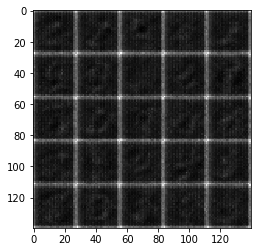

Epoch 1/2... Discriminator Loss:0.8187... Generator Loss:1.4155
Epoch 1/2... Discriminator Loss:0.9903... Generator Loss:0.9582
Epoch 1/2... Discriminator Loss:1.0712... Generator Loss:0.8281
Epoch 1/2... Discriminator Loss:0.9446... Generator Loss:1.1254
Epoch 1/2... Discriminator Loss:0.8659... Generator Loss:1.1919
Epoch 1/2... Discriminator Loss:0.8426... Generator Loss:1.2433
Epoch 1/2... Discriminator Loss:0.9378... Generator Loss:1.0028
Epoch 1/2... Discriminator Loss:0.7498... Generator Loss:1.5268
Epoch 1/2... Discriminator Loss:0.7680... Generator Loss:1.9421
Epoch 1/2... Discriminator Loss:0.8238... Generator Loss:1.1007


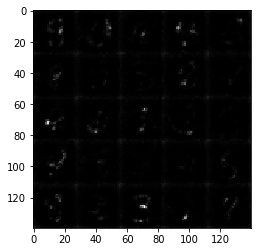

Epoch 1/2... Discriminator Loss:0.8268... Generator Loss:2.4938
Epoch 1/2... Discriminator Loss:0.7632... Generator Loss:1.2677
Epoch 1/2... Discriminator Loss:0.7491... Generator Loss:1.6751
Epoch 1/2... Discriminator Loss:0.7563... Generator Loss:2.0054
Epoch 1/2... Discriminator Loss:0.7735... Generator Loss:1.2816
Epoch 1/2... Discriminator Loss:0.7398... Generator Loss:1.4374
Epoch 1/2... Discriminator Loss:0.6664... Generator Loss:1.7796
Epoch 1/2... Discriminator Loss:0.6370... Generator Loss:1.9553
Epoch 1/2... Discriminator Loss:0.6954... Generator Loss:1.4421
Epoch 1/2... Discriminator Loss:0.6767... Generator Loss:1.8427


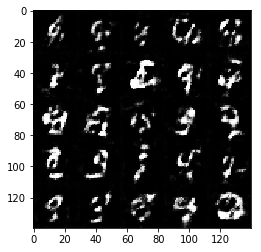

Epoch 1/2... Discriminator Loss:0.7614... Generator Loss:1.2431
Epoch 1/2... Discriminator Loss:0.6464... Generator Loss:1.8445
Epoch 1/2... Discriminator Loss:0.6133... Generator Loss:1.7972
Epoch 1/2... Discriminator Loss:0.6361... Generator Loss:1.8286
Epoch 1/2... Discriminator Loss:0.5385... Generator Loss:2.2605
Epoch 1/2... Discriminator Loss:0.7003... Generator Loss:2.1897
Epoch 1/2... Discriminator Loss:0.6466... Generator Loss:1.6288
Epoch 1/2... Discriminator Loss:0.5946... Generator Loss:2.1033
Epoch 1/2... Discriminator Loss:0.6140... Generator Loss:1.9750
Epoch 1/2... Discriminator Loss:0.7133... Generator Loss:1.5387


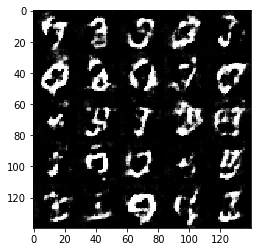

Epoch 1/2... Discriminator Loss:0.5805... Generator Loss:2.0506
Epoch 1/2... Discriminator Loss:0.6384... Generator Loss:2.3026
Epoch 1/2... Discriminator Loss:0.6430... Generator Loss:2.3626
Epoch 1/2... Discriminator Loss:0.7115... Generator Loss:1.9515
Epoch 1/2... Discriminator Loss:0.7428... Generator Loss:2.1901
Epoch 1/2... Discriminator Loss:0.9195... Generator Loss:2.8893
Epoch 1/2... Discriminator Loss:0.9114... Generator Loss:3.2894
Epoch 1/2... Discriminator Loss:0.7345... Generator Loss:1.4456
Epoch 1/2... Discriminator Loss:0.6987... Generator Loss:1.7670
Epoch 1/2... Discriminator Loss:0.8015... Generator Loss:1.2463


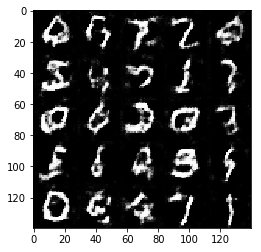

Epoch 1/2... Discriminator Loss:0.6801... Generator Loss:1.5501
Epoch 1/2... Discriminator Loss:0.6763... Generator Loss:1.5494
Epoch 1/2... Discriminator Loss:0.6942... Generator Loss:1.5531
Epoch 1/2... Discriminator Loss:0.8425... Generator Loss:2.6427
Epoch 1/2... Discriminator Loss:0.7219... Generator Loss:1.6671
Epoch 1/2... Discriminator Loss:1.0605... Generator Loss:2.6587
Epoch 1/2... Discriminator Loss:0.8305... Generator Loss:2.3147
Epoch 1/2... Discriminator Loss:0.9473... Generator Loss:0.9828
Epoch 1/2... Discriminator Loss:0.9455... Generator Loss:0.9872
Epoch 1/2... Discriminator Loss:0.9448... Generator Loss:0.9649


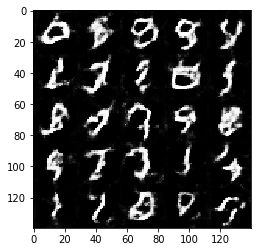

Epoch 1/2... Discriminator Loss:1.0483... Generator Loss:2.6073
Epoch 1/2... Discriminator Loss:0.7193... Generator Loss:1.5428
Epoch 1/2... Discriminator Loss:1.0095... Generator Loss:2.7042
Epoch 1/2... Discriminator Loss:0.7240... Generator Loss:1.5318
Epoch 1/2... Discriminator Loss:0.8541... Generator Loss:1.1944
Epoch 1/2... Discriminator Loss:0.7306... Generator Loss:1.9787
Epoch 1/2... Discriminator Loss:0.7787... Generator Loss:1.5796
Epoch 1/2... Discriminator Loss:0.9041... Generator Loss:1.1814
Epoch 1/2... Discriminator Loss:0.7654... Generator Loss:1.4909
Epoch 1/2... Discriminator Loss:0.7775... Generator Loss:1.3528


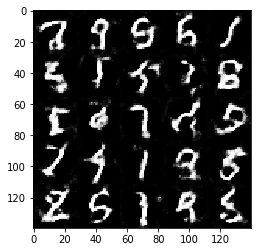

Epoch 1/2... Discriminator Loss:0.7869... Generator Loss:1.6287
Epoch 1/2... Discriminator Loss:0.7767... Generator Loss:1.6597
Epoch 1/2... Discriminator Loss:0.9206... Generator Loss:1.7735
Epoch 1/2... Discriminator Loss:1.1689... Generator Loss:0.7233
Epoch 1/2... Discriminator Loss:0.8021... Generator Loss:1.3360
Epoch 1/2... Discriminator Loss:0.8868... Generator Loss:1.7380
Epoch 1/2... Discriminator Loss:0.7921... Generator Loss:1.4235
Epoch 1/2... Discriminator Loss:0.8889... Generator Loss:1.0683
Epoch 1/2... Discriminator Loss:0.6718... Generator Loss:1.8256
Epoch 1/2... Discriminator Loss:0.7855... Generator Loss:1.3984


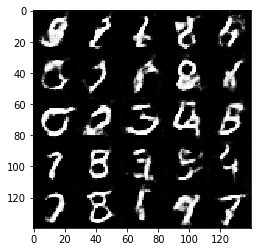

Epoch 1/2... Discriminator Loss:0.6519... Generator Loss:1.9804
Epoch 1/2... Discriminator Loss:1.0493... Generator Loss:2.7391
Epoch 1/2... Discriminator Loss:0.7528... Generator Loss:1.7969
Epoch 1/2... Discriminator Loss:0.8963... Generator Loss:1.4145
Epoch 1/2... Discriminator Loss:0.9363... Generator Loss:1.0446
Epoch 1/2... Discriminator Loss:0.9992... Generator Loss:0.9415
Epoch 1/2... Discriminator Loss:0.7788... Generator Loss:1.4547
Epoch 1/2... Discriminator Loss:0.9527... Generator Loss:0.9199
Epoch 1/2... Discriminator Loss:0.8723... Generator Loss:1.0652
Epoch 1/2... Discriminator Loss:0.9011... Generator Loss:1.1704


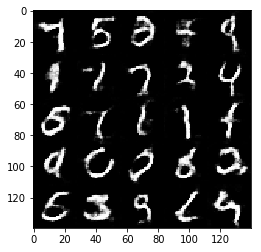

Epoch 1/2... Discriminator Loss:0.8710... Generator Loss:1.1227
Epoch 1/2... Discriminator Loss:0.7288... Generator Loss:1.6319
Epoch 1/2... Discriminator Loss:0.7872... Generator Loss:2.3471
Epoch 2/2... Discriminator Loss:0.7027... Generator Loss:2.2254
Epoch 2/2... Discriminator Loss:1.0213... Generator Loss:2.2126
Epoch 2/2... Discriminator Loss:0.7564... Generator Loss:1.5201
Epoch 2/2... Discriminator Loss:0.7544... Generator Loss:1.5169
Epoch 2/2... Discriminator Loss:0.7285... Generator Loss:1.4256
Epoch 2/2... Discriminator Loss:0.8104... Generator Loss:1.4674
Epoch 2/2... Discriminator Loss:0.9408... Generator Loss:1.7598


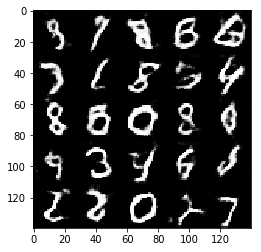

Epoch 2/2... Discriminator Loss:0.9531... Generator Loss:0.9248
Epoch 2/2... Discriminator Loss:0.7030... Generator Loss:1.6142
Epoch 2/2... Discriminator Loss:1.1146... Generator Loss:0.7116
Epoch 2/2... Discriminator Loss:0.7205... Generator Loss:1.6875
Epoch 2/2... Discriminator Loss:0.7994... Generator Loss:1.5533
Epoch 2/2... Discriminator Loss:0.8015... Generator Loss:1.2431
Epoch 2/2... Discriminator Loss:0.7513... Generator Loss:1.5418
Epoch 2/2... Discriminator Loss:0.8108... Generator Loss:1.2174
Epoch 2/2... Discriminator Loss:0.7212... Generator Loss:1.4157
Epoch 2/2... Discriminator Loss:0.8004... Generator Loss:2.3030


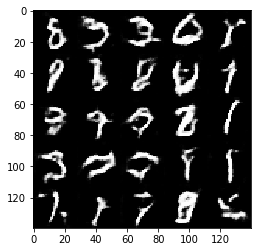

Epoch 2/2... Discriminator Loss:0.7541... Generator Loss:1.9361
Epoch 2/2... Discriminator Loss:0.9351... Generator Loss:2.3510
Epoch 2/2... Discriminator Loss:0.7401... Generator Loss:1.5037
Epoch 2/2... Discriminator Loss:0.8340... Generator Loss:1.1336
Epoch 2/2... Discriminator Loss:0.7131... Generator Loss:1.4836
Epoch 2/2... Discriminator Loss:0.9231... Generator Loss:0.9923
Epoch 2/2... Discriminator Loss:0.9569... Generator Loss:2.2228
Epoch 2/2... Discriminator Loss:0.7597... Generator Loss:1.4252
Epoch 2/2... Discriminator Loss:0.8459... Generator Loss:1.1842
Epoch 2/2... Discriminator Loss:0.7706... Generator Loss:1.2551


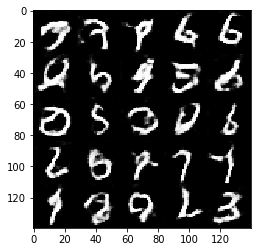

Epoch 2/2... Discriminator Loss:0.7023... Generator Loss:1.4604
Epoch 2/2... Discriminator Loss:0.7601... Generator Loss:1.2885
Epoch 2/2... Discriminator Loss:0.8904... Generator Loss:1.0439
Epoch 2/2... Discriminator Loss:0.7250... Generator Loss:1.6270
Epoch 2/2... Discriminator Loss:0.7026... Generator Loss:1.8204
Epoch 2/2... Discriminator Loss:0.8574... Generator Loss:1.1739
Epoch 2/2... Discriminator Loss:0.7930... Generator Loss:2.2854
Epoch 2/2... Discriminator Loss:0.9155... Generator Loss:0.9908
Epoch 2/2... Discriminator Loss:0.6221... Generator Loss:1.9095
Epoch 2/2... Discriminator Loss:0.6891... Generator Loss:1.6004


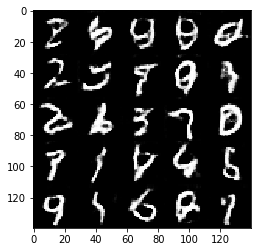

Epoch 2/2... Discriminator Loss:0.7077... Generator Loss:1.9336
Epoch 2/2... Discriminator Loss:0.6688... Generator Loss:1.5833
Epoch 2/2... Discriminator Loss:0.9699... Generator Loss:0.9542
Epoch 2/2... Discriminator Loss:0.7732... Generator Loss:1.4112
Epoch 2/2... Discriminator Loss:0.7024... Generator Loss:1.7732
Epoch 2/2... Discriminator Loss:0.8004... Generator Loss:1.8820
Epoch 2/2... Discriminator Loss:1.0332... Generator Loss:2.8480
Epoch 2/2... Discriminator Loss:0.9033... Generator Loss:1.0566
Epoch 2/2... Discriminator Loss:0.8091... Generator Loss:1.2997
Epoch 2/2... Discriminator Loss:1.0400... Generator Loss:3.2143


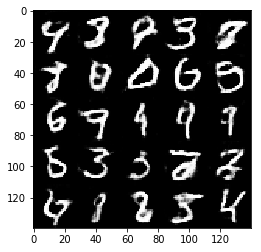

Epoch 2/2... Discriminator Loss:0.6907... Generator Loss:1.5744
Epoch 2/2... Discriminator Loss:0.7035... Generator Loss:1.7297
Epoch 2/2... Discriminator Loss:0.7704... Generator Loss:1.8140
Epoch 2/2... Discriminator Loss:0.7295... Generator Loss:1.6473
Epoch 2/2... Discriminator Loss:0.8401... Generator Loss:1.1470
Epoch 2/2... Discriminator Loss:0.6851... Generator Loss:2.1359
Epoch 2/2... Discriminator Loss:0.6596... Generator Loss:1.8713
Epoch 2/2... Discriminator Loss:0.6933... Generator Loss:1.5541
Epoch 2/2... Discriminator Loss:0.6507... Generator Loss:2.5875
Epoch 2/2... Discriminator Loss:0.7042... Generator Loss:1.3878


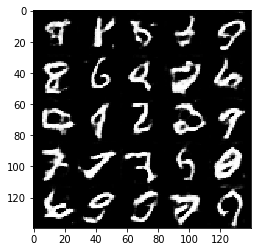

Epoch 2/2... Discriminator Loss:0.8519... Generator Loss:1.2782
Epoch 2/2... Discriminator Loss:0.7320... Generator Loss:1.5192
Epoch 2/2... Discriminator Loss:0.8848... Generator Loss:1.0703
Epoch 2/2... Discriminator Loss:0.7224... Generator Loss:1.8440
Epoch 2/2... Discriminator Loss:0.6730... Generator Loss:1.4783
Epoch 2/2... Discriminator Loss:1.0484... Generator Loss:0.8526
Epoch 2/2... Discriminator Loss:0.6986... Generator Loss:2.1432
Epoch 2/2... Discriminator Loss:0.7133... Generator Loss:1.4843
Epoch 2/2... Discriminator Loss:0.6215... Generator Loss:1.9566
Epoch 2/2... Discriminator Loss:0.6660... Generator Loss:1.7009


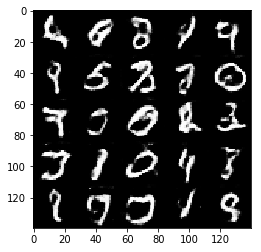

Epoch 2/2... Discriminator Loss:0.7409... Generator Loss:1.3392
Epoch 2/2... Discriminator Loss:1.4918... Generator Loss:3.1446
Epoch 2/2... Discriminator Loss:0.6499... Generator Loss:1.6240
Epoch 2/2... Discriminator Loss:0.6935... Generator Loss:1.6280
Epoch 2/2... Discriminator Loss:0.7695... Generator Loss:1.1975
Epoch 2/2... Discriminator Loss:0.6417... Generator Loss:1.9050
Epoch 2/2... Discriminator Loss:0.6500... Generator Loss:1.6989
Epoch 2/2... Discriminator Loss:0.6262... Generator Loss:1.7370
Epoch 2/2... Discriminator Loss:0.6917... Generator Loss:1.7768
Epoch 2/2... Discriminator Loss:0.8205... Generator Loss:1.0920


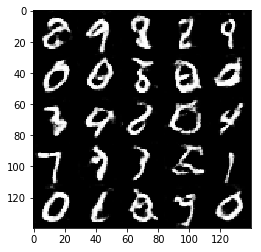

Epoch 2/2... Discriminator Loss:0.6168... Generator Loss:1.9243
Epoch 2/2... Discriminator Loss:0.7311... Generator Loss:1.3354
Epoch 2/2... Discriminator Loss:1.1260... Generator Loss:0.8225
Epoch 2/2... Discriminator Loss:0.9634... Generator Loss:2.7256
Epoch 2/2... Discriminator Loss:0.5764... Generator Loss:2.0484
Epoch 2/2... Discriminator Loss:0.7540... Generator Loss:1.6491
Epoch 2/2... Discriminator Loss:0.7376... Generator Loss:1.8651
Epoch 2/2... Discriminator Loss:0.7184... Generator Loss:1.4189
Epoch 2/2... Discriminator Loss:0.8139... Generator Loss:1.1939
Epoch 2/2... Discriminator Loss:0.6459... Generator Loss:1.8760


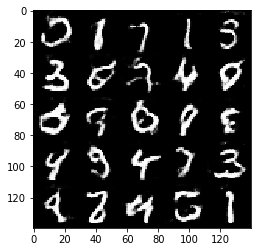

Epoch 2/2... Discriminator Loss:0.8032... Generator Loss:1.1979
Epoch 2/2... Discriminator Loss:1.0074... Generator Loss:0.8554
Epoch 2/2... Discriminator Loss:0.6371... Generator Loss:2.1871
Epoch 2/2... Discriminator Loss:0.7656... Generator Loss:1.2842
Epoch 2/2... Discriminator Loss:2.4641... Generator Loss:4.4911
Epoch 2/2... Discriminator Loss:0.7226... Generator Loss:1.6495
Epoch 2/2... Discriminator Loss:0.7009... Generator Loss:1.4949


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss:0.7813... Generator Loss:19.4658
Epoch 1/2... Discriminator Loss:0.4975... Generator Loss:19.5037
Epoch 1/2... Discriminator Loss:0.4211... Generator Loss:7.1960
Epoch 1/2... Discriminator Loss:0.3658... Generator Loss:6.1639
Epoch 1/2... Discriminator Loss:0.4157... Generator Loss:3.3174
Epoch 1/2... Discriminator Loss:1.5757... Generator Loss:0.6903
Epoch 1/2... Discriminator Loss:0.6378... Generator Loss:1.8021
Epoch 1/2... Discriminator Loss:0.4675... Generator Loss:2.6952
Epoch 1/2... Discriminator Loss:0.7220... Generator Loss:1.7880
Epoch 1/2... Discriminator Loss:0.5923... Generator Loss:2.2706


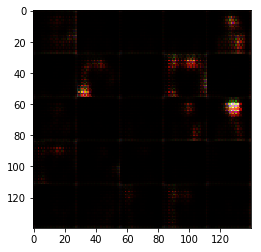

Epoch 1/2... Discriminator Loss:0.9364... Generator Loss:1.1227
Epoch 1/2... Discriminator Loss:0.9011... Generator Loss:1.3083
Epoch 1/2... Discriminator Loss:0.5703... Generator Loss:3.2440
Epoch 1/2... Discriminator Loss:0.6527... Generator Loss:1.6847
Epoch 1/2... Discriminator Loss:1.2710... Generator Loss:0.6499
Epoch 1/2... Discriminator Loss:0.9856... Generator Loss:0.9351
Epoch 1/2... Discriminator Loss:0.9485... Generator Loss:1.1869
Epoch 1/2... Discriminator Loss:1.1868... Generator Loss:0.8908
Epoch 1/2... Discriminator Loss:1.4416... Generator Loss:0.4944
Epoch 1/2... Discriminator Loss:1.3729... Generator Loss:0.7107


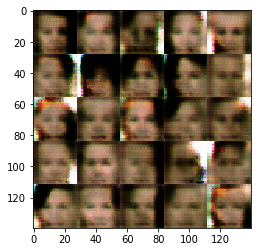

Epoch 1/2... Discriminator Loss:1.0851... Generator Loss:1.0422
Epoch 1/2... Discriminator Loss:1.2046... Generator Loss:1.0668
Epoch 1/2... Discriminator Loss:1.6328... Generator Loss:0.3726
Epoch 1/2... Discriminator Loss:1.9745... Generator Loss:2.7615
Epoch 1/2... Discriminator Loss:1.3207... Generator Loss:0.7954
Epoch 1/2... Discriminator Loss:1.2673... Generator Loss:2.1007
Epoch 1/2... Discriminator Loss:1.1326... Generator Loss:0.7342
Epoch 1/2... Discriminator Loss:1.2008... Generator Loss:0.9164
Epoch 1/2... Discriminator Loss:1.1500... Generator Loss:0.7000
Epoch 1/2... Discriminator Loss:0.9400... Generator Loss:1.6511


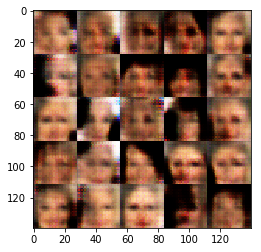

Epoch 1/2... Discriminator Loss:1.0941... Generator Loss:1.0005
Epoch 1/2... Discriminator Loss:0.9680... Generator Loss:1.3003
Epoch 1/2... Discriminator Loss:1.5381... Generator Loss:0.5219
Epoch 1/2... Discriminator Loss:1.7302... Generator Loss:1.5219
Epoch 1/2... Discriminator Loss:1.0184... Generator Loss:1.1695
Epoch 1/2... Discriminator Loss:1.3885... Generator Loss:0.5479
Epoch 1/2... Discriminator Loss:1.2637... Generator Loss:1.4239
Epoch 1/2... Discriminator Loss:1.0587... Generator Loss:0.8063
Epoch 1/2... Discriminator Loss:1.2698... Generator Loss:0.6597
Epoch 1/2... Discriminator Loss:1.2262... Generator Loss:0.6973


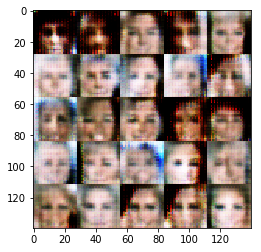

Epoch 1/2... Discriminator Loss:1.3145... Generator Loss:0.9959
Epoch 1/2... Discriminator Loss:1.1172... Generator Loss:1.5472
Epoch 1/2... Discriminator Loss:0.6068... Generator Loss:1.6411
Epoch 1/2... Discriminator Loss:1.0607... Generator Loss:1.6225
Epoch 1/2... Discriminator Loss:1.3419... Generator Loss:0.8602
Epoch 1/2... Discriminator Loss:1.4260... Generator Loss:0.5210
Epoch 1/2... Discriminator Loss:1.2066... Generator Loss:1.1450
Epoch 1/2... Discriminator Loss:1.3374... Generator Loss:0.6261
Epoch 1/2... Discriminator Loss:1.5920... Generator Loss:1.0137
Epoch 1/2... Discriminator Loss:1.3383... Generator Loss:0.6407


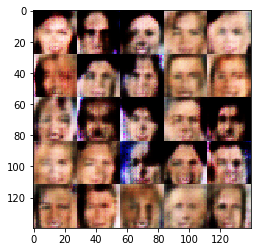

Epoch 1/2... Discriminator Loss:1.2096... Generator Loss:0.6858
Epoch 1/2... Discriminator Loss:1.2549... Generator Loss:1.2152
Epoch 1/2... Discriminator Loss:1.4978... Generator Loss:0.5762
Epoch 1/2... Discriminator Loss:1.1901... Generator Loss:0.9293
Epoch 1/2... Discriminator Loss:1.2581... Generator Loss:0.8483
Epoch 1/2... Discriminator Loss:1.1654... Generator Loss:1.2396
Epoch 1/2... Discriminator Loss:0.9160... Generator Loss:1.4650
Epoch 1/2... Discriminator Loss:1.3961... Generator Loss:0.5832
Epoch 1/2... Discriminator Loss:1.0638... Generator Loss:0.7302
Epoch 1/2... Discriminator Loss:1.1918... Generator Loss:0.7819


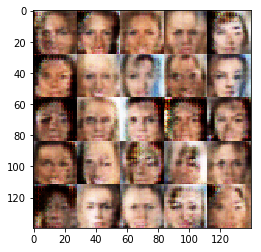

Epoch 1/2... Discriminator Loss:1.3090... Generator Loss:0.7496
Epoch 1/2... Discriminator Loss:1.2062... Generator Loss:1.3732
Epoch 1/2... Discriminator Loss:1.3189... Generator Loss:1.1401
Epoch 1/2... Discriminator Loss:1.4004... Generator Loss:0.6787
Epoch 1/2... Discriminator Loss:1.1197... Generator Loss:0.9286
Epoch 1/2... Discriminator Loss:1.1454... Generator Loss:1.1269
Epoch 1/2... Discriminator Loss:1.4740... Generator Loss:2.3007
Epoch 1/2... Discriminator Loss:2.0899... Generator Loss:2.5031
Epoch 1/2... Discriminator Loss:1.1348... Generator Loss:1.0565
Epoch 1/2... Discriminator Loss:1.1071... Generator Loss:1.2862


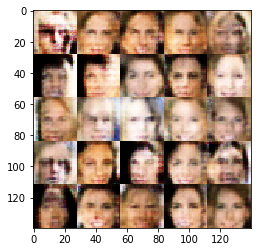

Epoch 1/2... Discriminator Loss:1.4650... Generator Loss:1.3073
Epoch 1/2... Discriminator Loss:1.4298... Generator Loss:0.5712
Epoch 1/2... Discriminator Loss:1.1045... Generator Loss:1.4323
Epoch 1/2... Discriminator Loss:1.1536... Generator Loss:1.2139
Epoch 1/2... Discriminator Loss:1.1990... Generator Loss:1.1704
Epoch 1/2... Discriminator Loss:1.4431... Generator Loss:0.5520
Epoch 1/2... Discriminator Loss:1.3154... Generator Loss:1.4365
Epoch 1/2... Discriminator Loss:1.2977... Generator Loss:1.1878
Epoch 1/2... Discriminator Loss:1.3431... Generator Loss:0.8610
Epoch 1/2... Discriminator Loss:1.3701... Generator Loss:0.5825


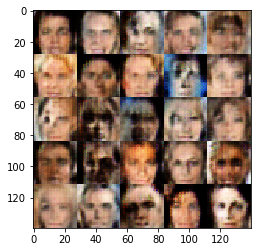

Epoch 1/2... Discriminator Loss:1.4793... Generator Loss:1.3025
Epoch 1/2... Discriminator Loss:1.5909... Generator Loss:0.7233
Epoch 1/2... Discriminator Loss:1.2973... Generator Loss:0.8366
Epoch 1/2... Discriminator Loss:1.1076... Generator Loss:1.4556
Epoch 1/2... Discriminator Loss:1.1324... Generator Loss:0.8763
Epoch 1/2... Discriminator Loss:1.4383... Generator Loss:1.4262
Epoch 1/2... Discriminator Loss:1.2705... Generator Loss:0.7333
Epoch 1/2... Discriminator Loss:1.4810... Generator Loss:0.4605
Epoch 1/2... Discriminator Loss:1.1988... Generator Loss:1.0151
Epoch 1/2... Discriminator Loss:1.2574... Generator Loss:1.0798


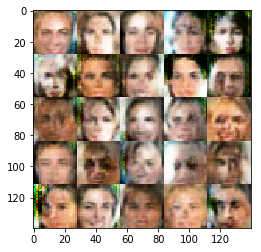

Epoch 1/2... Discriminator Loss:1.1989... Generator Loss:0.7014
Epoch 1/2... Discriminator Loss:2.6675... Generator Loss:2.7039
Epoch 1/2... Discriminator Loss:1.2483... Generator Loss:0.7148
Epoch 1/2... Discriminator Loss:1.2905... Generator Loss:1.2406
Epoch 1/2... Discriminator Loss:1.1405... Generator Loss:0.7418
Epoch 1/2... Discriminator Loss:1.2524... Generator Loss:0.9201
Epoch 1/2... Discriminator Loss:1.1588... Generator Loss:0.8367
Epoch 1/2... Discriminator Loss:1.4184... Generator Loss:0.8837
Epoch 1/2... Discriminator Loss:1.2490... Generator Loss:1.0977
Epoch 1/2... Discriminator Loss:1.3759... Generator Loss:1.6644


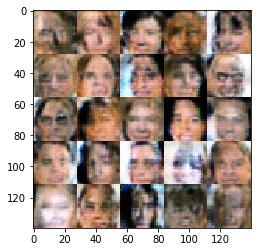

Epoch 1/2... Discriminator Loss:1.3582... Generator Loss:0.8173
Epoch 1/2... Discriminator Loss:1.1629... Generator Loss:0.8645
Epoch 1/2... Discriminator Loss:1.1848... Generator Loss:1.0619
Epoch 1/2... Discriminator Loss:1.4502... Generator Loss:0.8472
Epoch 1/2... Discriminator Loss:1.6601... Generator Loss:0.4870
Epoch 1/2... Discriminator Loss:1.1793... Generator Loss:0.8188
Epoch 1/2... Discriminator Loss:1.1993... Generator Loss:1.0139
Epoch 1/2... Discriminator Loss:1.3412... Generator Loss:1.1193
Epoch 1/2... Discriminator Loss:1.1432... Generator Loss:0.6319
Epoch 1/2... Discriminator Loss:1.3277... Generator Loss:0.9339


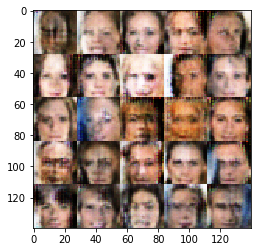

Epoch 1/2... Discriminator Loss:1.2089... Generator Loss:0.8191
Epoch 1/2... Discriminator Loss:1.3076... Generator Loss:0.9067
Epoch 1/2... Discriminator Loss:1.3148... Generator Loss:0.9899
Epoch 1/2... Discriminator Loss:1.4641... Generator Loss:0.9139
Epoch 1/2... Discriminator Loss:1.5699... Generator Loss:0.9172
Epoch 1/2... Discriminator Loss:1.1816... Generator Loss:0.9415
Epoch 1/2... Discriminator Loss:1.0142... Generator Loss:0.8135
Epoch 1/2... Discriminator Loss:1.4807... Generator Loss:0.5789
Epoch 1/2... Discriminator Loss:1.2354... Generator Loss:0.8113
Epoch 1/2... Discriminator Loss:1.2516... Generator Loss:0.9153


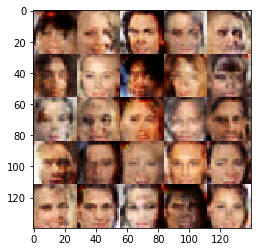

Epoch 1/2... Discriminator Loss:1.4256... Generator Loss:0.5385
Epoch 1/2... Discriminator Loss:1.5101... Generator Loss:0.8486
Epoch 1/2... Discriminator Loss:1.1842... Generator Loss:0.9547
Epoch 1/2... Discriminator Loss:1.3793... Generator Loss:0.5590
Epoch 1/2... Discriminator Loss:1.2599... Generator Loss:0.6832
Epoch 1/2... Discriminator Loss:1.2007... Generator Loss:0.9259
Epoch 1/2... Discriminator Loss:1.3775... Generator Loss:0.5155
Epoch 1/2... Discriminator Loss:1.2489... Generator Loss:1.2952
Epoch 1/2... Discriminator Loss:1.0610... Generator Loss:0.7018
Epoch 1/2... Discriminator Loss:1.3034... Generator Loss:0.8433


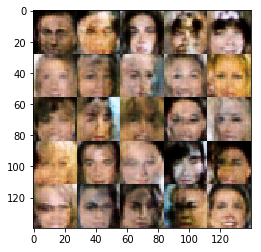

Epoch 1/2... Discriminator Loss:1.2928... Generator Loss:0.8172
Epoch 1/2... Discriminator Loss:1.2314... Generator Loss:0.7848
Epoch 1/2... Discriminator Loss:1.2575... Generator Loss:0.7787
Epoch 1/2... Discriminator Loss:1.4629... Generator Loss:1.1085
Epoch 1/2... Discriminator Loss:1.2791... Generator Loss:1.1246
Epoch 1/2... Discriminator Loss:1.2391... Generator Loss:0.8792
Epoch 1/2... Discriminator Loss:1.2961... Generator Loss:0.7907
Epoch 1/2... Discriminator Loss:1.2950... Generator Loss:1.0042
Epoch 1/2... Discriminator Loss:1.3082... Generator Loss:0.6498
Epoch 1/2... Discriminator Loss:1.6002... Generator Loss:1.7981


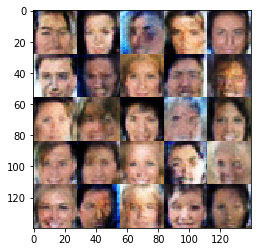

Epoch 1/2... Discriminator Loss:1.3372... Generator Loss:0.8498
Epoch 1/2... Discriminator Loss:1.3912... Generator Loss:1.0888
Epoch 1/2... Discriminator Loss:1.0527... Generator Loss:0.9703
Epoch 1/2... Discriminator Loss:1.5349... Generator Loss:1.0809
Epoch 1/2... Discriminator Loss:1.2019... Generator Loss:0.8307
Epoch 1/2... Discriminator Loss:1.4881... Generator Loss:0.7998
Epoch 1/2... Discriminator Loss:1.4237... Generator Loss:0.7967
Epoch 1/2... Discriminator Loss:1.2799... Generator Loss:0.6893
Epoch 1/2... Discriminator Loss:1.2856... Generator Loss:1.0853
Epoch 1/2... Discriminator Loss:1.3436... Generator Loss:1.0049


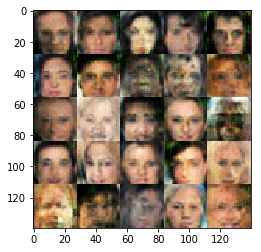

Epoch 1/2... Discriminator Loss:1.2507... Generator Loss:0.7446
Epoch 1/2... Discriminator Loss:1.4477... Generator Loss:1.2009
Epoch 1/2... Discriminator Loss:1.0339... Generator Loss:0.8773
Epoch 1/2... Discriminator Loss:1.3214... Generator Loss:1.1542
Epoch 1/2... Discriminator Loss:1.2873... Generator Loss:1.3911
Epoch 1/2... Discriminator Loss:1.5449... Generator Loss:1.4009
Epoch 1/2... Discriminator Loss:1.7598... Generator Loss:0.6332
Epoch 1/2... Discriminator Loss:1.3438... Generator Loss:0.7399
Epoch 1/2... Discriminator Loss:1.3871... Generator Loss:0.9713
Epoch 1/2... Discriminator Loss:1.3235... Generator Loss:0.7452


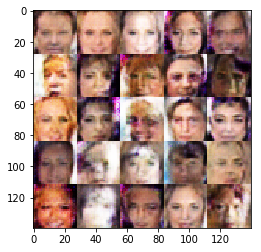

Epoch 1/2... Discriminator Loss:1.1816... Generator Loss:0.6931
Epoch 1/2... Discriminator Loss:1.3902... Generator Loss:0.8677
Epoch 1/2... Discriminator Loss:1.1791... Generator Loss:0.8479
Epoch 1/2... Discriminator Loss:1.2821... Generator Loss:0.6541
Epoch 1/2... Discriminator Loss:1.3069... Generator Loss:1.4871
Epoch 1/2... Discriminator Loss:1.1325... Generator Loss:0.9600
Epoch 1/2... Discriminator Loss:1.4472... Generator Loss:1.4081
Epoch 1/2... Discriminator Loss:1.4142... Generator Loss:1.2012
Epoch 1/2... Discriminator Loss:0.9709... Generator Loss:1.4218
Epoch 1/2... Discriminator Loss:1.2829... Generator Loss:0.7570


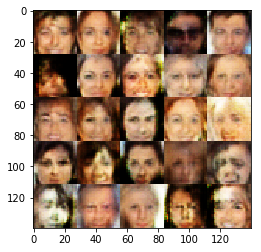

Epoch 1/2... Discriminator Loss:1.5412... Generator Loss:1.4478
Epoch 1/2... Discriminator Loss:1.3411... Generator Loss:0.9680
Epoch 1/2... Discriminator Loss:1.2779... Generator Loss:0.9548
Epoch 1/2... Discriminator Loss:1.3339... Generator Loss:0.9523
Epoch 1/2... Discriminator Loss:1.2631... Generator Loss:0.9328
Epoch 1/2... Discriminator Loss:1.3499... Generator Loss:0.8777
Epoch 1/2... Discriminator Loss:1.2132... Generator Loss:0.7657
Epoch 1/2... Discriminator Loss:1.1901... Generator Loss:0.7800
Epoch 1/2... Discriminator Loss:1.3393... Generator Loss:0.7528
Epoch 1/2... Discriminator Loss:1.1486... Generator Loss:0.7921


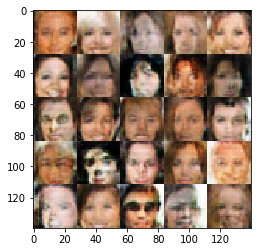

Epoch 1/2... Discriminator Loss:1.2773... Generator Loss:0.9390
Epoch 1/2... Discriminator Loss:1.2704... Generator Loss:1.6706
Epoch 1/2... Discriminator Loss:1.3035... Generator Loss:0.9363
Epoch 1/2... Discriminator Loss:1.4382... Generator Loss:1.0131
Epoch 1/2... Discriminator Loss:1.0696... Generator Loss:0.8400
Epoch 1/2... Discriminator Loss:1.2155... Generator Loss:0.8759
Epoch 1/2... Discriminator Loss:1.3296... Generator Loss:0.7249
Epoch 1/2... Discriminator Loss:1.4115... Generator Loss:1.1737
Epoch 1/2... Discriminator Loss:1.3210... Generator Loss:0.8130
Epoch 1/2... Discriminator Loss:1.2997... Generator Loss:1.2364


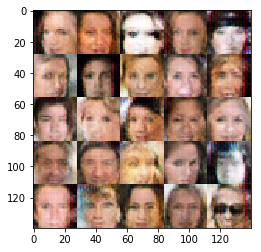

Epoch 1/2... Discriminator Loss:1.2616... Generator Loss:1.2994
Epoch 1/2... Discriminator Loss:1.3049... Generator Loss:1.0896
Epoch 1/2... Discriminator Loss:1.2736... Generator Loss:1.1368
Epoch 1/2... Discriminator Loss:1.5690... Generator Loss:1.6825
Epoch 1/2... Discriminator Loss:1.1100... Generator Loss:0.8741
Epoch 1/2... Discriminator Loss:1.3875... Generator Loss:0.5417
Epoch 1/2... Discriminator Loss:1.1215... Generator Loss:0.7628
Epoch 1/2... Discriminator Loss:1.3375... Generator Loss:0.7111
Epoch 1/2... Discriminator Loss:1.3794... Generator Loss:0.9152
Epoch 1/2... Discriminator Loss:1.1416... Generator Loss:0.9513


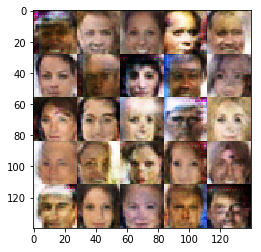

Epoch 1/2... Discriminator Loss:1.2728... Generator Loss:1.1505
Epoch 1/2... Discriminator Loss:1.3436... Generator Loss:0.9280
Epoch 1/2... Discriminator Loss:1.3885... Generator Loss:0.6767
Epoch 1/2... Discriminator Loss:1.2649... Generator Loss:0.8350
Epoch 1/2... Discriminator Loss:1.4076... Generator Loss:1.3471
Epoch 1/2... Discriminator Loss:1.3667... Generator Loss:0.7020
Epoch 1/2... Discriminator Loss:1.4075... Generator Loss:0.9048
Epoch 1/2... Discriminator Loss:1.3528... Generator Loss:0.9577
Epoch 1/2... Discriminator Loss:1.3513... Generator Loss:1.1095
Epoch 1/2... Discriminator Loss:1.1965... Generator Loss:0.7278


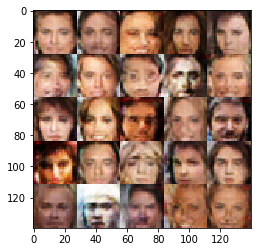

Epoch 1/2... Discriminator Loss:1.2592... Generator Loss:0.7783
Epoch 1/2... Discriminator Loss:1.2207... Generator Loss:1.4108
Epoch 1/2... Discriminator Loss:1.0318... Generator Loss:1.0574
Epoch 1/2... Discriminator Loss:1.3484... Generator Loss:1.0451
Epoch 1/2... Discriminator Loss:1.0491... Generator Loss:0.7751
Epoch 1/2... Discriminator Loss:1.3957... Generator Loss:0.8088
Epoch 1/2... Discriminator Loss:1.3463... Generator Loss:0.9811
Epoch 1/2... Discriminator Loss:1.1155... Generator Loss:0.8984
Epoch 1/2... Discriminator Loss:1.2185... Generator Loss:0.7863
Epoch 1/2... Discriminator Loss:1.2161... Generator Loss:0.8529


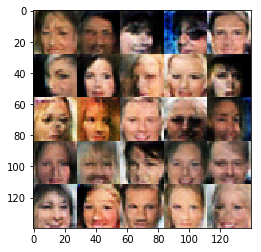

Epoch 1/2... Discriminator Loss:1.3182... Generator Loss:0.6477
Epoch 1/2... Discriminator Loss:1.3902... Generator Loss:0.8489
Epoch 1/2... Discriminator Loss:1.3218... Generator Loss:1.0987
Epoch 1/2... Discriminator Loss:1.3970... Generator Loss:0.6507
Epoch 1/2... Discriminator Loss:1.3747... Generator Loss:0.6269
Epoch 1/2... Discriminator Loss:1.2322... Generator Loss:0.9070
Epoch 1/2... Discriminator Loss:1.2988... Generator Loss:0.7993
Epoch 1/2... Discriminator Loss:1.5211... Generator Loss:0.7225
Epoch 1/2... Discriminator Loss:1.4615... Generator Loss:0.6096
Epoch 1/2... Discriminator Loss:1.1877... Generator Loss:0.6707


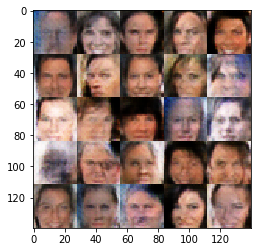

Epoch 1/2... Discriminator Loss:1.4311... Generator Loss:0.6991
Epoch 1/2... Discriminator Loss:1.0460... Generator Loss:0.8982
Epoch 1/2... Discriminator Loss:1.4664... Generator Loss:1.2696
Epoch 1/2... Discriminator Loss:1.3615... Generator Loss:0.6301
Epoch 1/2... Discriminator Loss:1.2521... Generator Loss:0.7610
Epoch 1/2... Discriminator Loss:1.2793... Generator Loss:0.7101
Epoch 1/2... Discriminator Loss:1.3418... Generator Loss:0.6574
Epoch 1/2... Discriminator Loss:1.2343... Generator Loss:0.8624
Epoch 1/2... Discriminator Loss:1.3709... Generator Loss:1.0334
Epoch 1/2... Discriminator Loss:1.3748... Generator Loss:1.2396


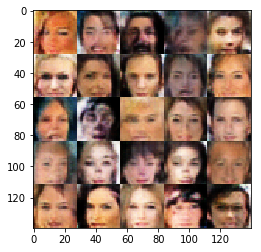

Epoch 1/2... Discriminator Loss:1.3554... Generator Loss:1.1982
Epoch 1/2... Discriminator Loss:1.1463... Generator Loss:1.1267
Epoch 1/2... Discriminator Loss:1.1301... Generator Loss:0.8908
Epoch 1/2... Discriminator Loss:1.4247... Generator Loss:0.5259
Epoch 1/2... Discriminator Loss:1.1533... Generator Loss:0.7903
Epoch 1/2... Discriminator Loss:1.2829... Generator Loss:0.9439
Epoch 1/2... Discriminator Loss:1.1783... Generator Loss:0.8864
Epoch 1/2... Discriminator Loss:1.3062... Generator Loss:0.8078
Epoch 1/2... Discriminator Loss:1.3177... Generator Loss:0.6545
Epoch 1/2... Discriminator Loss:1.3418... Generator Loss:1.0437


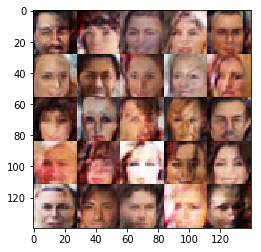

Epoch 1/2... Discriminator Loss:1.1392... Generator Loss:0.8834
Epoch 1/2... Discriminator Loss:1.3081... Generator Loss:0.8136
Epoch 1/2... Discriminator Loss:1.3819... Generator Loss:0.6833
Epoch 1/2... Discriminator Loss:1.3335... Generator Loss:0.7444
Epoch 1/2... Discriminator Loss:1.3856... Generator Loss:0.9652
Epoch 1/2... Discriminator Loss:1.2821... Generator Loss:0.6570
Epoch 1/2... Discriminator Loss:1.2355... Generator Loss:0.6801
Epoch 1/2... Discriminator Loss:1.2568... Generator Loss:0.7387
Epoch 1/2... Discriminator Loss:1.2213... Generator Loss:0.9221
Epoch 1/2... Discriminator Loss:1.2849... Generator Loss:0.7701


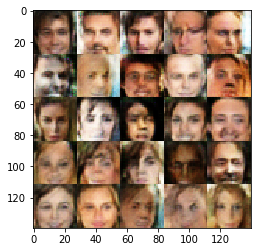

Epoch 1/2... Discriminator Loss:1.3428... Generator Loss:0.7121
Epoch 1/2... Discriminator Loss:1.2279... Generator Loss:1.0657
Epoch 1/2... Discriminator Loss:1.2549... Generator Loss:0.9103
Epoch 1/2... Discriminator Loss:1.2090... Generator Loss:0.7550
Epoch 1/2... Discriminator Loss:1.3719... Generator Loss:0.7454
Epoch 1/2... Discriminator Loss:1.3465... Generator Loss:0.6862
Epoch 1/2... Discriminator Loss:1.1212... Generator Loss:0.8466
Epoch 1/2... Discriminator Loss:1.3586... Generator Loss:0.7289
Epoch 1/2... Discriminator Loss:1.3929... Generator Loss:0.6986
Epoch 1/2... Discriminator Loss:1.3343... Generator Loss:0.8453


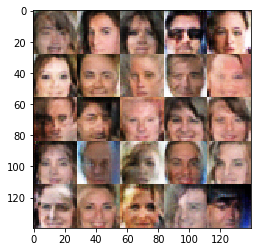

Epoch 1/2... Discriminator Loss:1.2351... Generator Loss:0.9286
Epoch 1/2... Discriminator Loss:1.3057... Generator Loss:0.9286
Epoch 1/2... Discriminator Loss:1.2218... Generator Loss:0.8699
Epoch 1/2... Discriminator Loss:1.4504... Generator Loss:1.0250
Epoch 1/2... Discriminator Loss:1.2595... Generator Loss:0.7866
Epoch 1/2... Discriminator Loss:1.4453... Generator Loss:0.9654
Epoch 1/2... Discriminator Loss:1.3187... Generator Loss:0.8582
Epoch 1/2... Discriminator Loss:1.3323... Generator Loss:0.6486
Epoch 1/2... Discriminator Loss:1.2008... Generator Loss:0.7064
Epoch 1/2... Discriminator Loss:1.2978... Generator Loss:0.9118


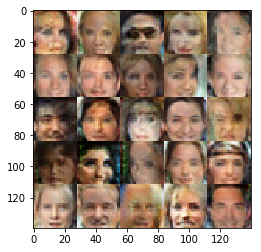

Epoch 1/2... Discriminator Loss:1.3848... Generator Loss:0.7588
Epoch 1/2... Discriminator Loss:1.3086... Generator Loss:0.6513
Epoch 1/2... Discriminator Loss:1.2618... Generator Loss:0.7016
Epoch 1/2... Discriminator Loss:1.4121... Generator Loss:0.6703
Epoch 1/2... Discriminator Loss:1.3935... Generator Loss:0.5511
Epoch 1/2... Discriminator Loss:1.3357... Generator Loss:0.8196
Epoch 1/2... Discriminator Loss:1.4183... Generator Loss:1.1929
Epoch 1/2... Discriminator Loss:1.2041... Generator Loss:1.0446
Epoch 1/2... Discriminator Loss:1.2939... Generator Loss:0.9689
Epoch 1/2... Discriminator Loss:1.2292... Generator Loss:0.7758


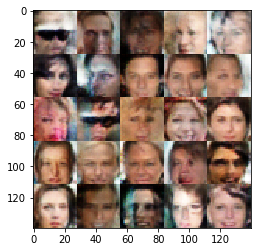

Epoch 1/2... Discriminator Loss:1.5567... Generator Loss:0.5866
Epoch 1/2... Discriminator Loss:1.2673... Generator Loss:0.8984
Epoch 1/2... Discriminator Loss:1.2853... Generator Loss:0.7967
Epoch 1/2... Discriminator Loss:1.3043... Generator Loss:0.7213
Epoch 1/2... Discriminator Loss:1.2926... Generator Loss:0.9940
Epoch 1/2... Discriminator Loss:1.4066... Generator Loss:0.9218
Epoch 1/2... Discriminator Loss:1.2503... Generator Loss:0.6519
Epoch 1/2... Discriminator Loss:1.3127... Generator Loss:0.7192
Epoch 1/2... Discriminator Loss:1.3479... Generator Loss:0.6670
Epoch 1/2... Discriminator Loss:1.2060... Generator Loss:0.8357


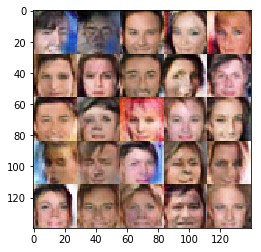

Epoch 1/2... Discriminator Loss:1.6415... Generator Loss:0.6503
Epoch 1/2... Discriminator Loss:1.2400... Generator Loss:1.1434
Epoch 1/2... Discriminator Loss:1.2987... Generator Loss:0.7771
Epoch 1/2... Discriminator Loss:1.1632... Generator Loss:0.7366
Epoch 1/2... Discriminator Loss:1.2836... Generator Loss:0.6545
Epoch 1/2... Discriminator Loss:1.4345... Generator Loss:0.8891
Epoch 1/2... Discriminator Loss:1.2822... Generator Loss:0.7444
Epoch 1/2... Discriminator Loss:1.3375... Generator Loss:1.0102
Epoch 1/2... Discriminator Loss:1.3331... Generator Loss:0.6886
Epoch 1/2... Discriminator Loss:1.2004... Generator Loss:0.6708


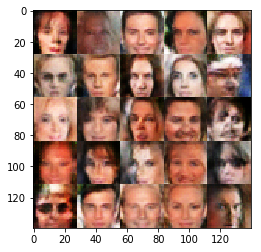

Epoch 1/2... Discriminator Loss:1.4182... Generator Loss:0.6769
Epoch 1/2... Discriminator Loss:1.3293... Generator Loss:0.9546
Epoch 1/2... Discriminator Loss:1.3170... Generator Loss:0.6548
Epoch 1/2... Discriminator Loss:1.2240... Generator Loss:1.0244
Epoch 1/2... Discriminator Loss:1.4454... Generator Loss:0.7926
Epoch 1/2... Discriminator Loss:1.2859... Generator Loss:0.7906
Epoch 2/2... Discriminator Loss:1.3469... Generator Loss:0.8541
Epoch 2/2... Discriminator Loss:1.2671... Generator Loss:0.9607
Epoch 2/2... Discriminator Loss:1.3649... Generator Loss:0.7323
Epoch 2/2... Discriminator Loss:1.2262... Generator Loss:0.9179


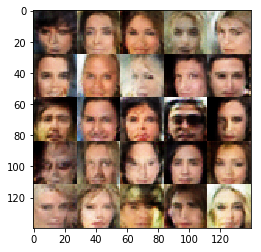

Epoch 2/2... Discriminator Loss:1.2418... Generator Loss:0.7303
Epoch 2/2... Discriminator Loss:1.3186... Generator Loss:0.9180
Epoch 2/2... Discriminator Loss:1.4414... Generator Loss:0.5992
Epoch 2/2... Discriminator Loss:1.2780... Generator Loss:0.9973
Epoch 2/2... Discriminator Loss:1.3765... Generator Loss:0.8473
Epoch 2/2... Discriminator Loss:1.2051... Generator Loss:0.9210
Epoch 2/2... Discriminator Loss:1.2706... Generator Loss:0.8028
Epoch 2/2... Discriminator Loss:1.2565... Generator Loss:1.0730
Epoch 2/2... Discriminator Loss:1.2810... Generator Loss:0.6163
Epoch 2/2... Discriminator Loss:1.3527... Generator Loss:0.7204


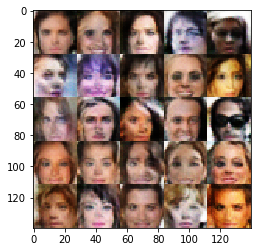

Epoch 2/2... Discriminator Loss:1.3237... Generator Loss:0.7168
Epoch 2/2... Discriminator Loss:1.3350... Generator Loss:0.6072
Epoch 2/2... Discriminator Loss:1.1350... Generator Loss:0.7975
Epoch 2/2... Discriminator Loss:1.3520... Generator Loss:0.6771
Epoch 2/2... Discriminator Loss:1.3870... Generator Loss:0.6329
Epoch 2/2... Discriminator Loss:1.2957... Generator Loss:0.7941
Epoch 2/2... Discriminator Loss:1.3215... Generator Loss:0.6540
Epoch 2/2... Discriminator Loss:1.1957... Generator Loss:0.7487
Epoch 2/2... Discriminator Loss:1.5284... Generator Loss:0.4740
Epoch 2/2... Discriminator Loss:1.3258... Generator Loss:0.6917


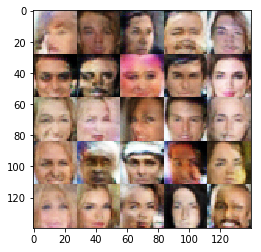

Epoch 2/2... Discriminator Loss:1.1858... Generator Loss:0.9295
Epoch 2/2... Discriminator Loss:1.2620... Generator Loss:0.8605
Epoch 2/2... Discriminator Loss:1.3869... Generator Loss:0.6755
Epoch 2/2... Discriminator Loss:1.3226... Generator Loss:0.7086
Epoch 2/2... Discriminator Loss:1.4311... Generator Loss:0.8942
Epoch 2/2... Discriminator Loss:1.3445... Generator Loss:0.6025
Epoch 2/2... Discriminator Loss:1.2863... Generator Loss:0.8716
Epoch 2/2... Discriminator Loss:1.2968... Generator Loss:0.6957
Epoch 2/2... Discriminator Loss:1.3685... Generator Loss:0.5852
Epoch 2/2... Discriminator Loss:1.4684... Generator Loss:0.5753


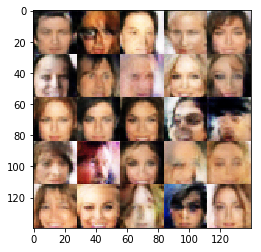

Epoch 2/2... Discriminator Loss:1.2398... Generator Loss:0.6906
Epoch 2/2... Discriminator Loss:1.2586... Generator Loss:0.6213
Epoch 2/2... Discriminator Loss:1.2841... Generator Loss:0.7369
Epoch 2/2... Discriminator Loss:1.3973... Generator Loss:1.0356
Epoch 2/2... Discriminator Loss:1.4279... Generator Loss:0.7195
Epoch 2/2... Discriminator Loss:1.0592... Generator Loss:0.8055
Epoch 2/2... Discriminator Loss:1.3720... Generator Loss:0.9398
Epoch 2/2... Discriminator Loss:1.3377... Generator Loss:0.6646
Epoch 2/2... Discriminator Loss:1.3655... Generator Loss:0.6671
Epoch 2/2... Discriminator Loss:1.3113... Generator Loss:1.0185


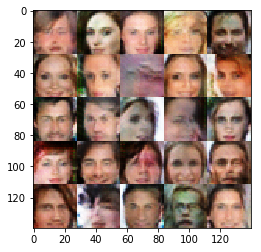

Epoch 2/2... Discriminator Loss:1.2920... Generator Loss:0.6293
Epoch 2/2... Discriminator Loss:1.3008... Generator Loss:0.8819
Epoch 2/2... Discriminator Loss:1.3287... Generator Loss:1.0465
Epoch 2/2... Discriminator Loss:1.4010... Generator Loss:0.8154
Epoch 2/2... Discriminator Loss:1.2615... Generator Loss:1.0253
Epoch 2/2... Discriminator Loss:1.3097... Generator Loss:0.8462
Epoch 2/2... Discriminator Loss:1.2465... Generator Loss:0.9369
Epoch 2/2... Discriminator Loss:1.3362... Generator Loss:1.0014
Epoch 2/2... Discriminator Loss:1.3395... Generator Loss:0.9265
Epoch 2/2... Discriminator Loss:1.3279... Generator Loss:0.7843


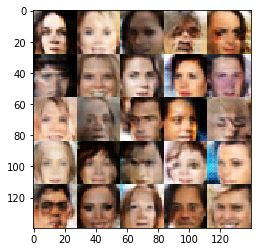

Epoch 2/2... Discriminator Loss:1.2397... Generator Loss:0.7159
Epoch 2/2... Discriminator Loss:1.2470... Generator Loss:0.6896
Epoch 2/2... Discriminator Loss:1.1464... Generator Loss:1.0533
Epoch 2/2... Discriminator Loss:1.3778... Generator Loss:0.8632
Epoch 2/2... Discriminator Loss:1.2777... Generator Loss:0.7485
Epoch 2/2... Discriminator Loss:1.3472... Generator Loss:0.9507
Epoch 2/2... Discriminator Loss:1.2850... Generator Loss:0.6799
Epoch 2/2... Discriminator Loss:1.4269... Generator Loss:0.9248
Epoch 2/2... Discriminator Loss:1.1973... Generator Loss:0.7827
Epoch 2/2... Discriminator Loss:1.2747... Generator Loss:0.7514


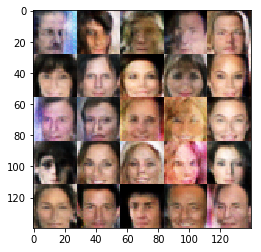

Epoch 2/2... Discriminator Loss:1.2216... Generator Loss:0.8004
Epoch 2/2... Discriminator Loss:1.2784... Generator Loss:0.7517
Epoch 2/2... Discriminator Loss:1.2294... Generator Loss:0.8607
Epoch 2/2... Discriminator Loss:1.3005... Generator Loss:0.8608
Epoch 2/2... Discriminator Loss:1.2720... Generator Loss:0.8089
Epoch 2/2... Discriminator Loss:1.3199... Generator Loss:0.7188
Epoch 2/2... Discriminator Loss:1.3161... Generator Loss:0.7319
Epoch 2/2... Discriminator Loss:1.3188... Generator Loss:1.1474
Epoch 2/2... Discriminator Loss:1.3535... Generator Loss:0.8533
Epoch 2/2... Discriminator Loss:1.2473... Generator Loss:0.8063


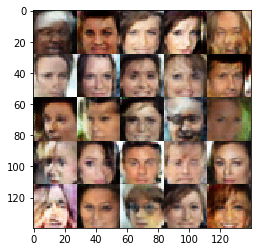

Epoch 2/2... Discriminator Loss:1.3595... Generator Loss:0.5969
Epoch 2/2... Discriminator Loss:1.2898... Generator Loss:0.8271
Epoch 2/2... Discriminator Loss:1.2732... Generator Loss:0.9263
Epoch 2/2... Discriminator Loss:1.2668... Generator Loss:0.7336
Epoch 2/2... Discriminator Loss:1.2492... Generator Loss:1.0573
Epoch 2/2... Discriminator Loss:1.2354... Generator Loss:0.7709
Epoch 2/2... Discriminator Loss:1.3301... Generator Loss:0.9838
Epoch 2/2... Discriminator Loss:1.2812... Generator Loss:0.8424
Epoch 2/2... Discriminator Loss:1.2348... Generator Loss:0.7060
Epoch 2/2... Discriminator Loss:1.3756... Generator Loss:1.2388


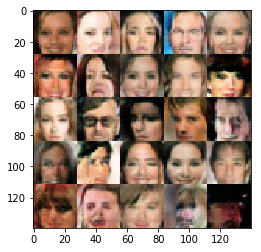

Epoch 2/2... Discriminator Loss:1.1600... Generator Loss:0.8019
Epoch 2/2... Discriminator Loss:1.4715... Generator Loss:0.7300
Epoch 2/2... Discriminator Loss:1.2469... Generator Loss:0.7886
Epoch 2/2... Discriminator Loss:1.4916... Generator Loss:0.6106
Epoch 2/2... Discriminator Loss:1.2547... Generator Loss:0.7538
Epoch 2/2... Discriminator Loss:1.3644... Generator Loss:0.7609
Epoch 2/2... Discriminator Loss:1.2227... Generator Loss:0.7704
Epoch 2/2... Discriminator Loss:1.4443... Generator Loss:0.9352
Epoch 2/2... Discriminator Loss:1.2230... Generator Loss:0.8260
Epoch 2/2... Discriminator Loss:1.2063... Generator Loss:0.7989


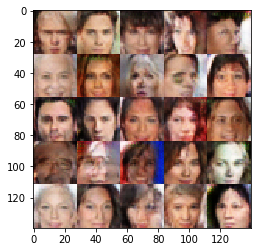

Epoch 2/2... Discriminator Loss:1.3782... Generator Loss:0.7900
Epoch 2/2... Discriminator Loss:1.2755... Generator Loss:0.8309
Epoch 2/2... Discriminator Loss:1.4241... Generator Loss:0.5871
Epoch 2/2... Discriminator Loss:1.2701... Generator Loss:0.8158
Epoch 2/2... Discriminator Loss:1.2442... Generator Loss:0.6775
Epoch 2/2... Discriminator Loss:1.3176... Generator Loss:0.8287
Epoch 2/2... Discriminator Loss:1.1007... Generator Loss:0.7947
Epoch 2/2... Discriminator Loss:1.3295... Generator Loss:0.9613
Epoch 2/2... Discriminator Loss:1.3839... Generator Loss:0.8306
Epoch 2/2... Discriminator Loss:1.4608... Generator Loss:1.1204


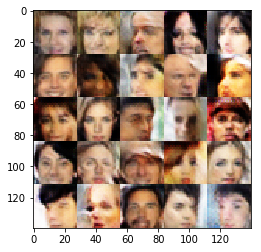

Epoch 2/2... Discriminator Loss:1.2463... Generator Loss:0.9199
Epoch 2/2... Discriminator Loss:1.4176... Generator Loss:0.7536
Epoch 2/2... Discriminator Loss:1.3738... Generator Loss:0.8427
Epoch 2/2... Discriminator Loss:1.3215... Generator Loss:0.6943
Epoch 2/2... Discriminator Loss:1.3100... Generator Loss:0.7198
Epoch 2/2... Discriminator Loss:1.5673... Generator Loss:0.9771
Epoch 2/2... Discriminator Loss:1.1198... Generator Loss:0.7019
Epoch 2/2... Discriminator Loss:1.3553... Generator Loss:0.6894
Epoch 2/2... Discriminator Loss:1.2746... Generator Loss:0.7866
Epoch 2/2... Discriminator Loss:1.3626... Generator Loss:0.7123


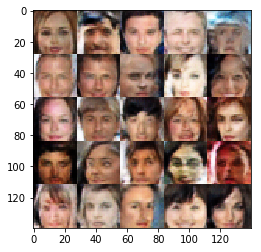

Epoch 2/2... Discriminator Loss:1.3972... Generator Loss:1.1920
Epoch 2/2... Discriminator Loss:1.2631... Generator Loss:0.6548
Epoch 2/2... Discriminator Loss:1.2158... Generator Loss:0.7533
Epoch 2/2... Discriminator Loss:1.3382... Generator Loss:1.0620
Epoch 2/2... Discriminator Loss:1.3534... Generator Loss:0.8233
Epoch 2/2... Discriminator Loss:1.1492... Generator Loss:0.9077
Epoch 2/2... Discriminator Loss:1.2783... Generator Loss:0.8309
Epoch 2/2... Discriminator Loss:1.2528... Generator Loss:0.7566
Epoch 2/2... Discriminator Loss:1.4811... Generator Loss:0.5795
Epoch 2/2... Discriminator Loss:1.3313... Generator Loss:0.6971


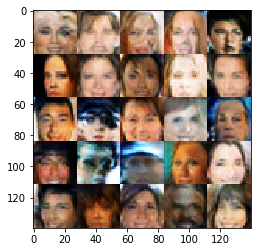

Epoch 2/2... Discriminator Loss:1.3415... Generator Loss:0.7619
Epoch 2/2... Discriminator Loss:1.3046... Generator Loss:0.8094
Epoch 2/2... Discriminator Loss:1.2333... Generator Loss:0.7080
Epoch 2/2... Discriminator Loss:1.3024... Generator Loss:0.7075
Epoch 2/2... Discriminator Loss:1.2659... Generator Loss:0.9155
Epoch 2/2... Discriminator Loss:1.2694... Generator Loss:0.7443
Epoch 2/2... Discriminator Loss:1.1974... Generator Loss:0.9141
Epoch 2/2... Discriminator Loss:1.3320... Generator Loss:0.8858
Epoch 2/2... Discriminator Loss:1.2517... Generator Loss:0.7229
Epoch 2/2... Discriminator Loss:1.3038... Generator Loss:0.9674


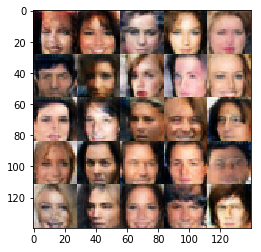

Epoch 2/2... Discriminator Loss:1.4099... Generator Loss:0.7067
Epoch 2/2... Discriminator Loss:1.2787... Generator Loss:0.8814
Epoch 2/2... Discriminator Loss:1.4806... Generator Loss:0.8092
Epoch 2/2... Discriminator Loss:1.3490... Generator Loss:0.7035
Epoch 2/2... Discriminator Loss:1.4224... Generator Loss:0.9868
Epoch 2/2... Discriminator Loss:1.3095... Generator Loss:0.7317
Epoch 2/2... Discriminator Loss:1.2843... Generator Loss:0.6603
Epoch 2/2... Discriminator Loss:1.4589... Generator Loss:0.6904
Epoch 2/2... Discriminator Loss:1.3552... Generator Loss:0.9495
Epoch 2/2... Discriminator Loss:1.4394... Generator Loss:0.9066


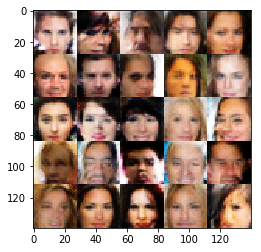

Epoch 2/2... Discriminator Loss:1.3020... Generator Loss:0.7235
Epoch 2/2... Discriminator Loss:1.3114... Generator Loss:0.7525
Epoch 2/2... Discriminator Loss:1.2274... Generator Loss:0.7859
Epoch 2/2... Discriminator Loss:1.3308... Generator Loss:0.7874
Epoch 2/2... Discriminator Loss:1.2593... Generator Loss:0.9134
Epoch 2/2... Discriminator Loss:1.2562... Generator Loss:0.7880
Epoch 2/2... Discriminator Loss:1.3150... Generator Loss:0.8266
Epoch 2/2... Discriminator Loss:1.3212... Generator Loss:0.7693
Epoch 2/2... Discriminator Loss:1.2655... Generator Loss:0.7786
Epoch 2/2... Discriminator Loss:1.1122... Generator Loss:0.7307


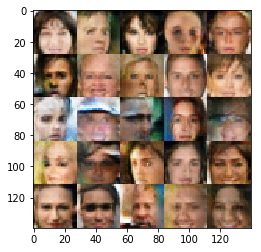

Epoch 2/2... Discriminator Loss:1.3184... Generator Loss:0.7146
Epoch 2/2... Discriminator Loss:1.2558... Generator Loss:0.8251
Epoch 2/2... Discriminator Loss:1.3024... Generator Loss:0.6389
Epoch 2/2... Discriminator Loss:1.3660... Generator Loss:0.7899
Epoch 2/2... Discriminator Loss:1.2050... Generator Loss:0.7445
Epoch 2/2... Discriminator Loss:1.4031... Generator Loss:0.6560
Epoch 2/2... Discriminator Loss:1.2994... Generator Loss:0.6765
Epoch 2/2... Discriminator Loss:1.1801... Generator Loss:0.8134
Epoch 2/2... Discriminator Loss:1.2553... Generator Loss:0.7664
Epoch 2/2... Discriminator Loss:1.2958... Generator Loss:0.6978


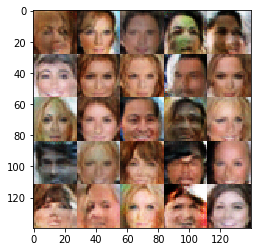

Epoch 2/2... Discriminator Loss:1.2631... Generator Loss:1.0077
Epoch 2/2... Discriminator Loss:1.3021... Generator Loss:0.7720
Epoch 2/2... Discriminator Loss:1.3096... Generator Loss:0.9537
Epoch 2/2... Discriminator Loss:1.3805... Generator Loss:0.7607
Epoch 2/2... Discriminator Loss:1.3652... Generator Loss:0.5624
Epoch 2/2... Discriminator Loss:1.2032... Generator Loss:0.7195
Epoch 2/2... Discriminator Loss:1.3651... Generator Loss:0.7728
Epoch 2/2... Discriminator Loss:1.3323... Generator Loss:0.9490
Epoch 2/2... Discriminator Loss:1.2994... Generator Loss:0.7321
Epoch 2/2... Discriminator Loss:1.3645... Generator Loss:0.8256


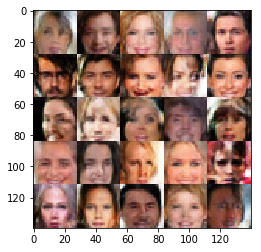

Epoch 2/2... Discriminator Loss:1.3830... Generator Loss:0.9772
Epoch 2/2... Discriminator Loss:1.2041... Generator Loss:0.8662
Epoch 2/2... Discriminator Loss:1.3696... Generator Loss:0.7737
Epoch 2/2... Discriminator Loss:1.3905... Generator Loss:0.7803
Epoch 2/2... Discriminator Loss:1.3826... Generator Loss:0.6503
Epoch 2/2... Discriminator Loss:1.3191... Generator Loss:0.7068
Epoch 2/2... Discriminator Loss:1.3334... Generator Loss:0.6658
Epoch 2/2... Discriminator Loss:1.1677... Generator Loss:0.8174
Epoch 2/2... Discriminator Loss:1.2750... Generator Loss:0.6782
Epoch 2/2... Discriminator Loss:1.5223... Generator Loss:0.5804


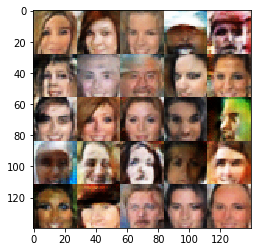

Epoch 2/2... Discriminator Loss:1.4573... Generator Loss:0.5430
Epoch 2/2... Discriminator Loss:1.2234... Generator Loss:0.7111
Epoch 2/2... Discriminator Loss:1.3718... Generator Loss:0.9184
Epoch 2/2... Discriminator Loss:1.3952... Generator Loss:0.6717
Epoch 2/2... Discriminator Loss:1.2868... Generator Loss:0.7231
Epoch 2/2... Discriminator Loss:1.1609... Generator Loss:0.6553
Epoch 2/2... Discriminator Loss:1.3999... Generator Loss:0.5474
Epoch 2/2... Discriminator Loss:1.2640... Generator Loss:0.7134
Epoch 2/2... Discriminator Loss:1.3135... Generator Loss:0.9385
Epoch 2/2... Discriminator Loss:1.2553... Generator Loss:0.8652


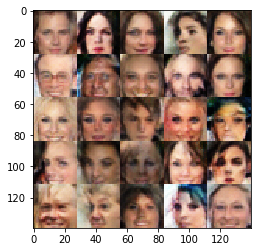

Epoch 2/2... Discriminator Loss:1.3669... Generator Loss:1.0843
Epoch 2/2... Discriminator Loss:1.2986... Generator Loss:0.7372
Epoch 2/2... Discriminator Loss:1.4781... Generator Loss:0.7447
Epoch 2/2... Discriminator Loss:1.2664... Generator Loss:0.8469
Epoch 2/2... Discriminator Loss:1.3088... Generator Loss:0.8878
Epoch 2/2... Discriminator Loss:1.3144... Generator Loss:0.8837
Epoch 2/2... Discriminator Loss:1.2433... Generator Loss:0.7326
Epoch 2/2... Discriminator Loss:1.5246... Generator Loss:0.4829
Epoch 2/2... Discriminator Loss:1.0848... Generator Loss:0.8117
Epoch 2/2... Discriminator Loss:1.2192... Generator Loss:1.2920


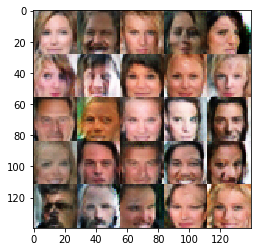

Epoch 2/2... Discriminator Loss:1.2253... Generator Loss:0.7045
Epoch 2/2... Discriminator Loss:1.3930... Generator Loss:0.9654
Epoch 2/2... Discriminator Loss:1.3037... Generator Loss:0.7108
Epoch 2/2... Discriminator Loss:1.3314... Generator Loss:0.7445
Epoch 2/2... Discriminator Loss:1.4167... Generator Loss:0.8763
Epoch 2/2... Discriminator Loss:1.2853... Generator Loss:0.7353
Epoch 2/2... Discriminator Loss:1.3677... Generator Loss:0.9124
Epoch 2/2... Discriminator Loss:1.2782... Generator Loss:0.6420
Epoch 2/2... Discriminator Loss:1.3050... Generator Loss:0.7455
Epoch 2/2... Discriminator Loss:1.3324... Generator Loss:0.6220


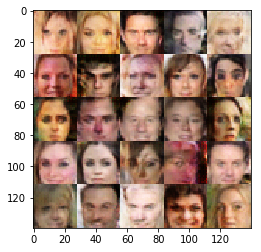

Epoch 2/2... Discriminator Loss:1.2474... Generator Loss:0.8626
Epoch 2/2... Discriminator Loss:1.2113... Generator Loss:0.7230
Epoch 2/2... Discriminator Loss:1.2677... Generator Loss:0.9788
Epoch 2/2... Discriminator Loss:1.3914... Generator Loss:0.8274
Epoch 2/2... Discriminator Loss:1.2963... Generator Loss:0.6317
Epoch 2/2... Discriminator Loss:1.3461... Generator Loss:0.8184
Epoch 2/2... Discriminator Loss:1.2417... Generator Loss:0.8019
Epoch 2/2... Discriminator Loss:1.2873... Generator Loss:0.5551
Epoch 2/2... Discriminator Loss:1.3266... Generator Loss:0.8652
Epoch 2/2... Discriminator Loss:1.3094... Generator Loss:0.8412


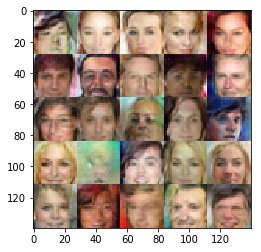

Epoch 2/2... Discriminator Loss:1.4135... Generator Loss:0.7952
Epoch 2/2... Discriminator Loss:1.3197... Generator Loss:0.6419
Epoch 2/2... Discriminator Loss:1.2635... Generator Loss:0.8334
Epoch 2/2... Discriminator Loss:1.3790... Generator Loss:0.7910
Epoch 2/2... Discriminator Loss:1.3539... Generator Loss:0.6036
Epoch 2/2... Discriminator Loss:1.2494... Generator Loss:0.9026
Epoch 2/2... Discriminator Loss:1.1994... Generator Loss:0.8191
Epoch 2/2... Discriminator Loss:1.4667... Generator Loss:0.5856
Epoch 2/2... Discriminator Loss:1.3071... Generator Loss:0.7751
Epoch 2/2... Discriminator Loss:1.3074... Generator Loss:0.7514


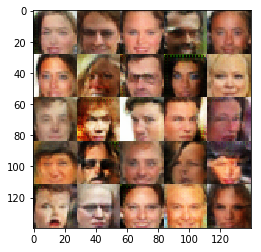

Epoch 2/2... Discriminator Loss:1.2959... Generator Loss:0.7293
Epoch 2/2... Discriminator Loss:1.4278... Generator Loss:0.9409
Epoch 2/2... Discriminator Loss:1.3524... Generator Loss:0.7580
Epoch 2/2... Discriminator Loss:1.4740... Generator Loss:0.7184
Epoch 2/2... Discriminator Loss:1.3942... Generator Loss:0.7468
Epoch 2/2... Discriminator Loss:1.3186... Generator Loss:0.7601
Epoch 2/2... Discriminator Loss:1.3979... Generator Loss:0.6061
Epoch 2/2... Discriminator Loss:1.3392... Generator Loss:0.8314
Epoch 2/2... Discriminator Loss:1.3785... Generator Loss:0.6898
Epoch 2/2... Discriminator Loss:1.1738... Generator Loss:0.6306


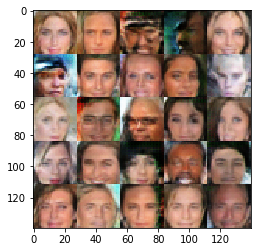

Epoch 2/2... Discriminator Loss:1.4322... Generator Loss:0.8249
Epoch 2/2... Discriminator Loss:1.2379... Generator Loss:0.8720
Epoch 2/2... Discriminator Loss:1.3739... Generator Loss:0.8119
Epoch 2/2... Discriminator Loss:1.3393... Generator Loss:0.8082
Epoch 2/2... Discriminator Loss:1.1174... Generator Loss:0.8031
Epoch 2/2... Discriminator Loss:1.3200... Generator Loss:0.7762
Epoch 2/2... Discriminator Loss:1.3654... Generator Loss:0.8121
Epoch 2/2... Discriminator Loss:1.2641... Generator Loss:0.8990
Epoch 2/2... Discriminator Loss:1.4302... Generator Loss:0.6159
Epoch 2/2... Discriminator Loss:1.2483... Generator Loss:0.9071


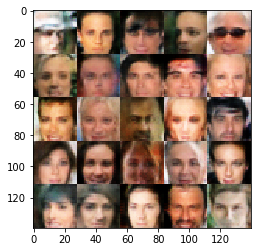

Epoch 2/2... Discriminator Loss:1.4361... Generator Loss:0.7455
Epoch 2/2... Discriminator Loss:1.2205... Generator Loss:0.9217
Epoch 2/2... Discriminator Loss:1.3258... Generator Loss:0.9121
Epoch 2/2... Discriminator Loss:1.3851... Generator Loss:0.8870
Epoch 2/2... Discriminator Loss:1.2826... Generator Loss:0.9997
Epoch 2/2... Discriminator Loss:1.3866... Generator Loss:0.6576
Epoch 2/2... Discriminator Loss:1.4661... Generator Loss:0.5837
Epoch 2/2... Discriminator Loss:1.2032... Generator Loss:0.9608
Epoch 2/2... Discriminator Loss:1.3631... Generator Loss:0.9282
Epoch 2/2... Discriminator Loss:1.3222... Generator Loss:0.9976


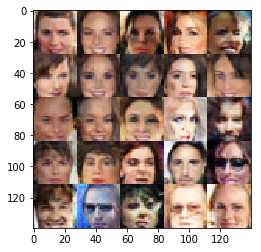

Epoch 2/2... Discriminator Loss:1.2922... Generator Loss:0.7546
Epoch 2/2... Discriminator Loss:1.3906... Generator Loss:0.8041
Epoch 2/2... Discriminator Loss:1.3518... Generator Loss:0.7822
Epoch 2/2... Discriminator Loss:1.2356... Generator Loss:0.7809
Epoch 2/2... Discriminator Loss:1.3852... Generator Loss:0.8120
Epoch 2/2... Discriminator Loss:1.2896... Generator Loss:0.6924
Epoch 2/2... Discriminator Loss:1.2905... Generator Loss:0.8207
Epoch 2/2... Discriminator Loss:1.1886... Generator Loss:0.8328
Epoch 2/2... Discriminator Loss:1.3417... Generator Loss:0.7601
Epoch 2/2... Discriminator Loss:1.3891... Generator Loss:0.7001


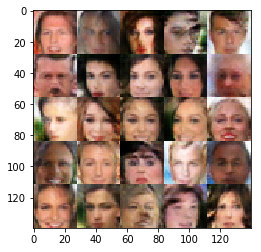

Epoch 2/2... Discriminator Loss:1.3706... Generator Loss:0.6151
Epoch 2/2... Discriminator Loss:1.2805... Generator Loss:0.6113
Epoch 2/2... Discriminator Loss:1.1840... Generator Loss:0.7228
Epoch 2/2... Discriminator Loss:1.0239... Generator Loss:0.7796
Epoch 2/2... Discriminator Loss:1.3583... Generator Loss:0.7575
Epoch 2/2... Discriminator Loss:1.3327... Generator Loss:0.8504
Epoch 2/2... Discriminator Loss:1.3798... Generator Loss:0.6872
Epoch 2/2... Discriminator Loss:1.3889... Generator Loss:0.7433
Epoch 2/2... Discriminator Loss:1.3582... Generator Loss:0.6438
Epoch 2/2... Discriminator Loss:1.3880... Generator Loss:0.8736


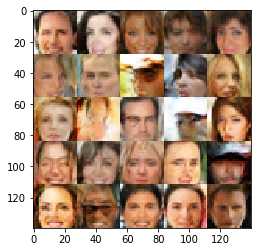

Epoch 2/2... Discriminator Loss:1.3928... Generator Loss:0.8468
Epoch 2/2... Discriminator Loss:1.2267... Generator Loss:0.7580
Epoch 2/2... Discriminator Loss:1.3290... Generator Loss:0.8243
Epoch 2/2... Discriminator Loss:1.6520... Generator Loss:0.4811
Epoch 2/2... Discriminator Loss:1.3772... Generator Loss:0.6080
Epoch 2/2... Discriminator Loss:1.3426... Generator Loss:0.9939
Epoch 2/2... Discriminator Loss:1.1350... Generator Loss:0.6598
Epoch 2/2... Discriminator Loss:1.3589... Generator Loss:0.7809
Epoch 2/2... Discriminator Loss:1.2699... Generator Loss:0.8282
Epoch 2/2... Discriminator Loss:1.2061... Generator Loss:0.7011


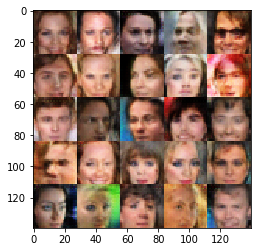

Epoch 2/2... Discriminator Loss:1.2831... Generator Loss:0.7422
Epoch 2/2... Discriminator Loss:1.3350... Generator Loss:0.7192
Epoch 2/2... Discriminator Loss:1.2972... Generator Loss:0.7143
Epoch 2/2... Discriminator Loss:1.3495... Generator Loss:0.8341
Epoch 2/2... Discriminator Loss:1.3428... Generator Loss:0.6213
Epoch 2/2... Discriminator Loss:1.3054... Generator Loss:0.7560
Epoch 2/2... Discriminator Loss:1.3284... Generator Loss:0.6921
Epoch 2/2... Discriminator Loss:1.3309... Generator Loss:0.7489
Epoch 2/2... Discriminator Loss:1.1841... Generator Loss:0.6606
Epoch 2/2... Discriminator Loss:1.2544... Generator Loss:0.8964


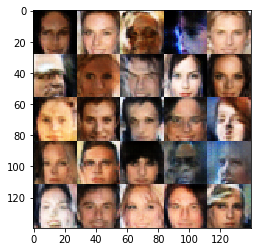

Epoch 2/2... Discriminator Loss:1.3764... Generator Loss:0.9923
Epoch 2/2... Discriminator Loss:1.3103... Generator Loss:0.8166
Epoch 2/2... Discriminator Loss:1.3166... Generator Loss:0.6767
Epoch 2/2... Discriminator Loss:1.3978... Generator Loss:0.7399
Epoch 2/2... Discriminator Loss:1.2903... Generator Loss:0.8003
Epoch 2/2... Discriminator Loss:1.4340... Generator Loss:0.8244
Epoch 2/2... Discriminator Loss:1.3777... Generator Loss:0.7926
Epoch 2/2... Discriminator Loss:1.2631... Generator Loss:0.8468
Epoch 2/2... Discriminator Loss:1.3922... Generator Loss:0.8564
Epoch 2/2... Discriminator Loss:1.2017... Generator Loss:0.7485


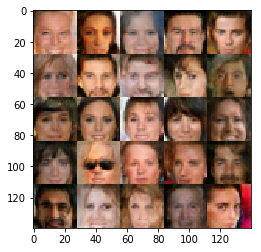

Epoch 2/2... Discriminator Loss:1.3831... Generator Loss:1.0527
Epoch 2/2... Discriminator Loss:1.4533... Generator Loss:0.5809
Epoch 2/2... Discriminator Loss:1.3079... Generator Loss:0.7674


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.